<a href="https://colab.research.google.com/github/spyderganeshan/Abstract_to_easy_read_NPL_project/blob/main/abstract_to_easy_read_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi, In this project we will be implemeting and evaluating a model that can convert abstract of a journal to more readable from.

journal paper=https://arxiv.org/pdf/1612.05251

*NOTE: "This notebook is made for educational purpose"*

OBJECTIVE

When given an abstract of a journal. The sentences in the abstract will be broken done into different segments such as objective, methods, background, result, and conclution which is easier to read and understand.

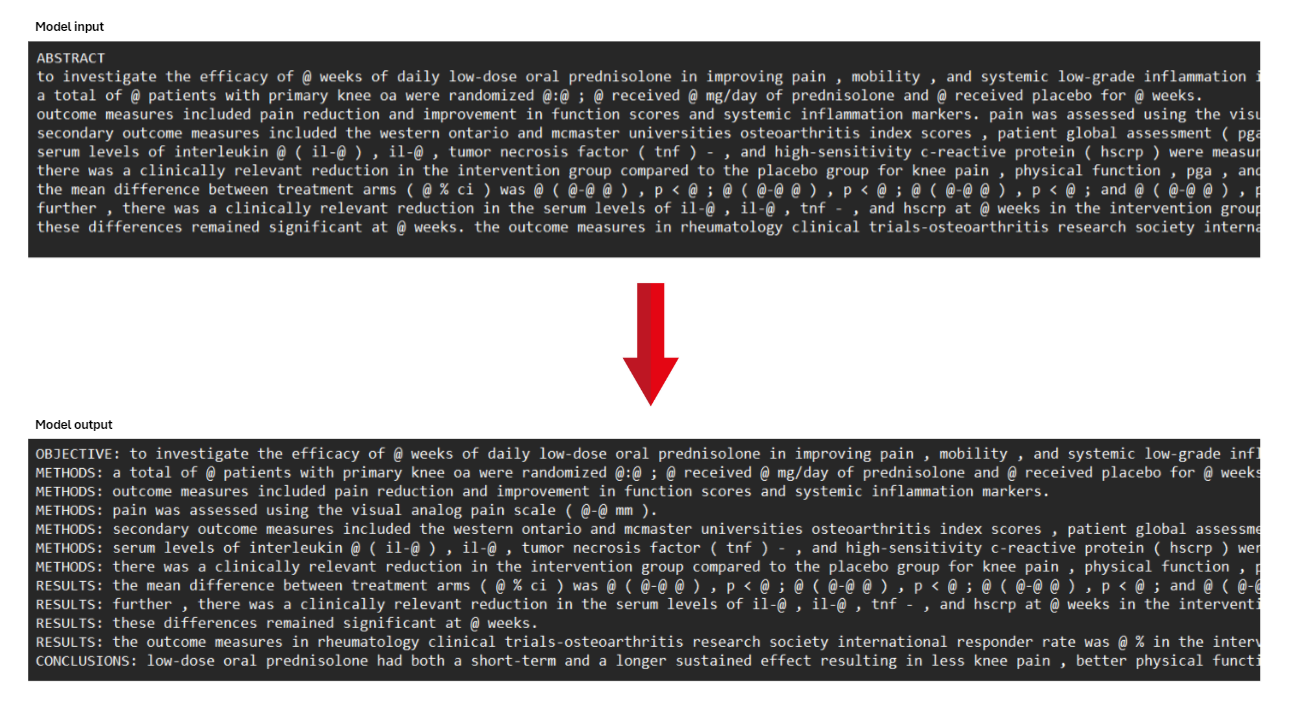

In [ ]:
import os
import pandas as pd
import  tensorflow as tf
import numpy as np
import string
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


In [ ]:
# access GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# get the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct # List all files and directories within pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


# DATA PREPROCESSING

In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

why numbers replaced with '@' sign?

*   Reducing Vocabulary Size: In natural
language processing (NLP), reducing the vocabulary size can be beneficial. Numbers can significantly increase the vocabulary size, and their exact values may not be as important as their presence.
*   Improving Model Generalization: For some tasks, the exact numeric values may not be crucial, and the model can learn better by generalizing over a single symbol rather than trying to learn patterns for every possible number





In [ ]:
# convert text to a list of lines
def text_to_line_list(filename):
  with open(filename, "r") as f:
    return f.readlines()
train_lines = text_to_line_list(filename=data_dir+"train.txt")
dev_lines = text_to_line_list(filename=data_dir+"dev.txt")
test_lines = text_to_line_list(filename=data_dir+"test.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
# convert lines to dict format
def process_lines_lists(lines_list):
  data_samples = []
  for line in lines_list:
    # print(line)
    main = {}
    if line.startswith('###'):
      temp = []
      line_number =  0
    elif line == '\n':
      for i in temp:
        i["total_lines"] = len(temp)
        data_samples.append(i)
    else:
      line_split = line.split('\t')
      main["target"] = line_split[0]
      main["text"] = line_split[1].lower() # convert to lower case
      main["line_number"] = line_number
      line_number += 1
      temp.append(main)
  return data_samples
train_sample = process_lines_lists(lines_list=train_lines)
dev_sample = process_lines_lists(lines_list=dev_lines)
test_sample = process_lines_lists(lines_list=test_lines)
train_sample[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .\n',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the wester

In [ ]:
# data to dataframe
train_df = pd.DataFrame(train_sample)
dev_df = pd.DataFrame(dev_sample)
test_df = pd.DataFrame(test_sample)
train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


In [ ]:
train_sentences = train_df.text.to_list()
dev_sentences = dev_df.text.to_list()
test_sentences = test_df.text.to_list()
train_sentences[:2]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .\n',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n']

# TOKEN VECTORIZATION
* Token_vectorization layer maps the words in our text directly to numbers

For vectorization with TextVectorization we need
* max_tokens: specifies the maximum number of unique tokens
* output_sequence_length: sets the length of the output sequences after vectorization(every scentence will be limited to 55 words,words after that are discarded)




In [ ]:
# in  order to get output_sequence_length lets take look at the lengths of the sentances
sentances_length = [len(sentence.split()) for sentence in train_sentences]
print("No: of words in 1st sentance=",sentances_length[0])
print("No: of words in 2st sentance=",sentances_length[1])

No: of words in 1st sentance= 49
No: of words in 2st sentance= 27


In [ ]:
# which scentence_length covers 95% of the length?
sequence_length = int(np.percentile(sentances_length,95))
sequence_length
# It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

55

In [ ]:
vocab=[]
for sent in train_sentences:
  vocab.extend(sent.split())
print("unique tokens/words in the train_scentences=",len(set(vocab)))

unique tokens/words in the train_scentences= 69732


In [ ]:
# its given that the training dataset has 68000 uniques tokens in the journal, so we use that(most common 68000 words will be taken from the dataset)
len_of_vocab = 68000

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=len_of_vocab,output_sequence_length=sequence_length)
text_vectorizer.adapt(train_sentences) # fitting
vocabulary = text_vectorizer.get_vocabulary()
print("vocabulary length:",len(vocabulary))
print("most common 5 words in the vocabulary=",vocabulary[:5])
print("train_scentence_1=",train_sentences[0])
print("orginal scetance length=",sentances_length[0])
print("After vectorization")
# for configuration of the vocabulary we can use text_vectorizer.get_config()
text_vectorizer(train_sentences[0])

vocabulary length: 64841
most common 5 words in the vocabulary= ['', '[UNK]', 'the', 'and', 'of']
train_scentence_1= to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .

orginal scetance length= 49
After vectorization


<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
          5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
       1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
        350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

# TOKEN EMBEDDING
* To create a richer numerical representation of our text, we can use an embedding.
* Each token (or integer index) will be embedded into a vector of length output_dim

In [ ]:
token_embed = tf.keras.layers.Embedding(input_dim=len(vocabulary),output_dim=128,mask_zero=True,name="token_embedding")
print("token embedding for 1st scentance:")
embedded_scentance = token_embed(text_vectorizer(train_sentences[0]))
embedded_scentance

token embedding for 1st scentance:


<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[-0.02222288, -0.01365414, -0.0316741 , ...,  0.04686573,
         0.02418664, -0.00504933],
       [ 0.04712817,  0.02177486, -0.04855639, ...,  0.02701882,
        -0.04519872,  0.01113677],
       [-0.03418452,  0.00614407,  0.04483148, ..., -0.01479996,
        -0.02330272,  0.04926055],
       ...,
       [-0.03079976, -0.02282347,  0.04289973, ...,  0.03716436,
        -0.03425465,  0.02664354],
       [-0.03079976, -0.02282347,  0.04289973, ...,  0.03716436,
        -0.03425465,  0.02664354],
       [-0.03079976, -0.02282347,  0.04289973, ...,  0.03716436,
        -0.03425465,  0.02664354]], dtype=float32)>

# CHARACTER VECTORIZATION
* Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

In [ ]:
split_char=lambda x: " ".join(list(x))
train_chars = [split_char(sentence) for sentence in train_sentences]
dev_chars = [split_char(sentence) for sentence in dev_sentences]
test_chars = [split_char(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   . \n'

In [ ]:
char_lengths = [len(sentence) for sentence in train_sentences]
char_lengths[0]

282

In [ ]:
# Find which character length covers 95% of sequences?
char_output_seq_char_len = int(np.percentile(char_lengths, 95))
char_output_seq_char_len

291

In [ ]:
# max_tokens: 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.
char_max_token = len(string.ascii_lowercase+string.digits+string.punctuation)+2 # no of char + space + oov token
char_max_token

70

In [ ]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=char_max_token,output_sequence_length=char_output_seq_char_len,standardize="lower_and_strip_punctuation",name="char_vectorizer")
char_vectorizer.adapt(train_chars)
print("train_scentence_1=",train_chars[0])
print("orginal scetance length=",char_lengths[0])
print("After vectorization")
# for configuration of the vocabulary we can use char_vectorizer.get_config()
char_vectorizer(train_chars[0])

train_scentence_1= t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   . 

orginal scetance length= 282
After vectorization


<tf.Tensor: shape=(291,), dtype=int64, numpy=
array([ 3,  7,  4,  6, 21,  2,  9,  3,  4, 18,  5,  3,  2,  3, 13,  2,  2,
       17, 17,  4, 11,  5, 11, 19,  7, 17, 20,  2,  2, 23,  9,  7, 17, 10,
        5,  4, 12, 19, 12,  7, 20, 10,  7,  9,  2,  7,  8,  5, 12, 14,  8,
        2, 10,  6,  4,  9,  7, 12,  7,  6,  2,  4,  6,  4, 15, 14,  8,  7,
       21,  4,  6, 18, 14,  5,  4,  6, 15,  7, 22,  4, 12,  4,  3, 19,  5,
        6, 10,  9, 19,  9,  3,  2, 15,  4, 11, 12,  7, 20, 18,  8,  5, 10,
        2,  4,  6, 17, 12,  5, 15, 15,  5,  3,  4,  7,  6,  4,  6,  3, 13,
        2,  9, 13,  7,  8,  3,  3,  2,  8, 15,  5,  6, 10, 20, 13,  2,  3,
       13,  2,  8,  3, 13,  2,  2, 17, 17,  2, 11,  3, 20,  7, 16, 12, 10,
       22,  2,  9, 16,  9,  3,  5,  4,  6,  2, 10,  5,  3, 20,  2,  2, 23,
        9,  4,  6,  7, 12, 10,  2,  8,  5, 10, 16, 12,  3,  9, 20,  4,  3,
       13, 15,  7, 10,  2,  8,  5,  3,  2,  3,  7,  9,  2, 21,  2,  8,  2,
       23,  6,  2,  2,  7,  9,  3,  2,  7,  5,  8,  3,

In [ ]:
char_vocabulary=char_vectorizer.get_vocabulary()
len(char_vocabulary)

28

# CHARACTER EMBEDDING

In [ ]:
# Creating char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocabulary), # number of different characters
                              output_dim=25, # embedding dimension of each character
                              mask_zero=False,
                              name="char_embed")
print("token embedding for 1st scentance:")
embedded_scentance = char_embed(char_vectorizer(train_chars[0]))
embedded_scentance

token embedding for 1st scentance:


<tf.Tensor: shape=(291, 25), dtype=float32, numpy=
array([[-0.04014355,  0.03824228, -0.04888368, ..., -0.01601083,
         0.01179766, -0.04114225],
       [ 0.03985871, -0.00737398,  0.03911903, ...,  0.00472947,
         0.0201211 , -0.00227196],
       [-0.04383482, -0.02255625, -0.04319974, ..., -0.02320604,
        -0.00278234,  0.04185638],
       ...,
       [-0.04353495, -0.03307908, -0.04922501, ...,  0.00798776,
        -0.02660795, -0.00276613],
       [-0.04353495, -0.03307908, -0.04922501, ...,  0.00798776,
        -0.02660795, -0.00276613],
       [-0.04353495, -0.03307908, -0.04922501, ...,  0.00798776,
        -0.02660795, -0.00276613]], dtype=float32)>

# FEATURE ENGINEERING

*   We can also consider incorporating the line number and total number as features that could contribute to the training of our model.



In [ ]:
# which line_number covers 97% of the length?
line_number_depth=int(np.percentile(train_df.line_number,98))
line_number_depth

15

In [ ]:
total_line_depth=int(np.percentile(train_df.total_lines,97))
total_line_depth # 97% of the data comes under 20

20

In [ ]:
#  we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.
# line_number
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_depth)
dev_line_numbers_one_hot = tf.one_hot(dev_df["line_number"].to_numpy(), depth=line_number_depth)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_depth)
# total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=total_line_depth)
dev_total_lines_one_hot = tf.one_hot(dev_df["total_lines"].to_numpy(), depth=total_line_depth)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=total_line_depth)

# DATASET PREPARE
Benefits of Using tf.data:

* Improved Performance: tf.data leverages vectorized operations and optimizations for data processing, leading to faster training times, especially when dealing with large datasets.
* Parallelization: tf.data pipelines can be parallelized across multiple CPU cores or GPUs, utilizing your hardware resources effectively. This can significantly speed up data preprocessing and training.
* Reduced Memory Footprint: By processing data in batches, tf.data helps manage memory usage more efficiently, especially when working with large datasets that might not fit entirely in memory at once.
* Reusability: You can create reusable data pipelines that can be easily integrated with different models, promoting code maintainability and modularity.
* Flexibility: tf.data provides a wide range of functionalities for data manipulation, allowing you to build complex and customized data pipelines for various machine learning tasks.



In [ ]:
# target variable
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
dev_labels_one_hot = one_hot_encoder.transform(dev_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_labels))
# batch: combines consecutive elements of the dataset into batches.
# prefetch: allows the data to be preloaded in the background, optimizing the input pipeline performance.
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print(train_pos_char_token_dataset)

dev_pos_char_token_data = tf.data.Dataset.from_tensor_slices((dev_line_numbers_one_hot,dev_total_lines_one_hot,dev_sentences,dev_chars))
dev_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(dev_labels_one_hot)
dev_pos_char_token_dataset = tf.data.Dataset.zip((dev_pos_char_token_data,dev_pos_char_token_labels))
dev_pos_char_token_dataset = dev_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print(dev_pos_char_token_dataset)

test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_total_lines_one_hot,test_sentences,test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print(test_pos_char_token_dataset)

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


# BUILD MODEL

In [ ]:
# model
# 1 token inputs
token_inputs = tf.keras.layers.Input(shape=(1,),dtype="string",name="token_inputs")
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

# 2 char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string",name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

print(token_model.outputs), print(char_model.outputs)

# 3 line number inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,),dtype=tf.int32,name="line_number_input")
line_number_output = tf.keras.layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,outputs=line_number_output)

# 4 total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,),dtype=tf.int32,name="total_lines_input")
total_lines_output = tf.keras.layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_output)

# 5 combining token and char embedding
combined_embedding = tf.keras.layers.Concatenate(name="token_and_char_combined_embedding")([token_model.output,char_model.output])
combined_embedding_layer = tf.keras.layers.Dense(128,activation="relu")(combined_embedding)
combined_embedding_layer_out = tf.keras.layers.Dropout(0.5)(combined_embedding_layer)

# 6 combine line number and total line with token and char embedding
combined_output = tf.keras.layers.Concatenate(name="token_char_positional_combined_embedding")([line_number_model.output,total_lines_model.output,combined_embedding_layer_out])

print(combined_output)
combined_output = tf.expand_dims(combined_output, axis=1)

# 7 output layer
bi_lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(combined_output)
output_layer = tf.keras.layers.Dense(5,activation="softmax",name="output_layer")(bi_lstm_layer)

model = tf.keras.Model(inputs=[line_number_model.input,total_lines_model.input,token_model.input,char_model.input],outputs=output_layer)
model.summary()

[<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional')>]
[<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional_1')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 192), dtype=tf.float32, name=None), name='token_char_positional_combined_embedding/concat:0', description="created by layer 'token_char_positional_combined_embedding'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_

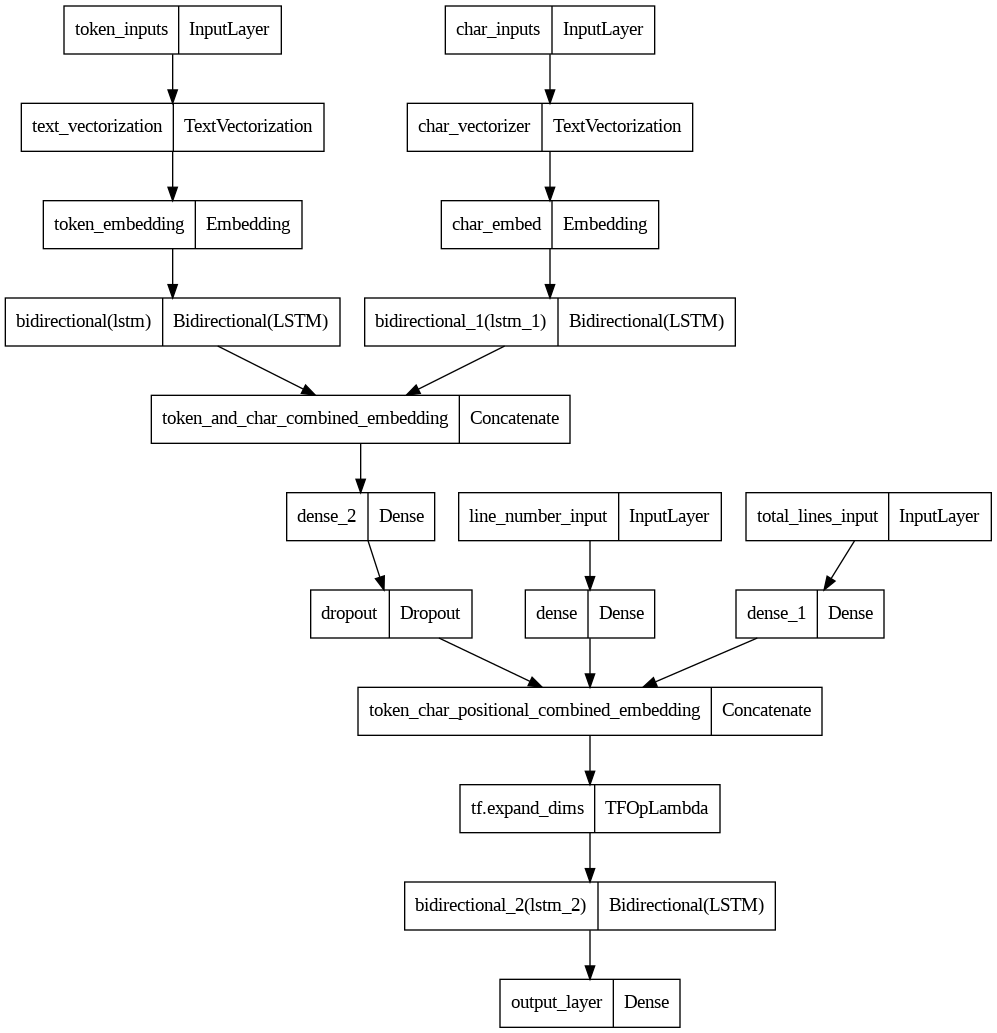

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# check if layers are trainable
for layer in model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7c4cd0aff6d0> True
<keras.src.engine.input_layer.InputLayer object at 0x7c4cd0ad2f80> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7c4d41269630> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7c4cd0cf5840> True
<keras.src.layers.core.embedding.Embedding object at 0x7c4cdfa75c90> True
<keras.src.layers.core.embedding.Embedding object at 0x7c4cd0ad0340> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7c4cdfa75de0> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7c4cc72e3fa0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7c4cc712d780> True
<keras.src.engine.input_layer.InputLayer object at 0x7c4cc7164a00> True
<keras.src.engine.input_layer.InputLayer object at 0x7c4cc712e800> True
<keras.src.layers.core.dense.Dense object at 0x7c4cc703a320> True
<keras.src.layers.core.dense.Dense object at 0x7c4cc726

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
# Fit the token, char and positional embedding model
history_model = model.fit(train_pos_char_token_dataset,
                              steps_per_epoch=32,
                              epochs=20,
                              validation_data=dev_pos_char_token_dataset,
                              validation_steps=32)
# if you have 1000 training samples, a batch size of 32, and steps_per_epoch=10, then in each epoch, Keras will use 10 batches (out of 31 total batches) to train the model.
# This means it will only see a portion of the training data during each epoch.

Epoch 1/20
32/32 [==============================] - 36s 589ms/step - loss: 1.5509 - accuracy: 0.3799 - val_loss: 1.5082 - val_accuracy: 0.3135
Epoch 2/20
32/32 [==============================] - 14s 455ms/step - loss: 1.4287 - accuracy: 0.4580 - val_loss: 1.2753 - val_accuracy: 0.5430
Epoch 3/20
32/32 [==============================] - 14s 449ms/step - loss: 1.2067 - accuracy: 0.6162 - val_loss: 1.1247 - val_accuracy: 0.7178
Epoch 4/20
32/32 [==============================] - 14s 456ms/step - loss: 1.1075 - accuracy: 0.7012 - val_loss: 1.0658 - val_accuracy: 0.6895
Epoch 5/20
32/32 [==============================] - 13s 423ms/step - loss: 1.0546 - accuracy: 0.7402 - val_loss: 1.0154 - val_accuracy: 0.7559
Epoch 6/20
32/32 [==============================] - 15s 479ms/step - loss: 1.0498 - accuracy: 0.7510 - val_loss: 0.9930 - val_accuracy: 0.7773
Epoch 7/20
32/32 [==============================] - 16s 503ms/step - loss: 1.0020 - accuracy: 0.7686 - val_loss: 0.9907 - val_accuracy: 0.7744

# TEST DATA PREDICTION

In [ ]:
# Make predictions on the test dataset
test_pred_probs = model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 [==============================] - 66s 63ms/step


In [ ]:
predicted_labels = []
categories=one_hot_encoder.categories_[0].tolist()
for i in test_preds:
  predicted_labels.append(categories[i])

In [ ]:
test_df["prediction"] = predicted_labels
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,9,OBJECTIVE,0.548468,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,9,METHODS,0.735363,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,9,METHODS,0.816052,False
3,RESULTS,survival analyses were used to assess the asso...,3,9,METHODS,0.839173,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,9,RESULTS,0.788231,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,9,RESULTS,0.858697,True
6,RESULTS,multivariable analyses revealed that patients ...,6,9,RESULTS,0.858973,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,9,CONCLUSIONS,0.750253,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,9,CONCLUSIONS,0.633818,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,13,BACKGROUND,0.674905,True


# EVALUVATION

In [ ]:
# Calculate f1score, precision, recall, and accuracy
f1 = f1_score(test_df.target,test_df.prediction, average='macro')
precision = precision_score(test_df["target"], test_df["prediction"], average="macro")
recall = recall_score(test_df["target"], test_df["prediction"], average="macro")
accuracy = accuracy_score(test_df["target"], test_df["prediction"])

# Print the results
print(f"F1 Score (Macro): {f1}")
print(f"Precision (Macro): {precision}")
print(f"Recall (Macro): {recall}")
print(f"Accuracy: {accuracy}")


F1 Score (Macro): 0.7892494718059408
Precision (Macro): 0.8077722591055743
Recall (Macro): 0.7780263775121559
Accuracy: 0.8377965820474531


# NEW PREDICTION

In [ ]:
abstract="This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group"
abstract

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group'

In [ ]:
import nltk
# Download the Punkt sentence tokenizer (one-time download)
nltk.download('punkt')
# Tokenize the text into sentences
sentences = nltk.sent_tokenize(abstract)
print(sentences)

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.', 'Participants were randomly assigned to treatment or wait-list conditions.', 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.', 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.', 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).', 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.', 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.', 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Get total number of lines
total_lines_in_sample = len(sentences)
# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(sentences):
  sample_dict = {}
  sample_dict["text"] = str(line).lower()
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'this rct examined the efficacy of a manualized social intervention for children with hfasds.',
  'line_number': 0,
  'total_lines': 8},
 {'text': 'participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 8},
 {'text': 'treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 8},
 {'text': 'a response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 8},
 {'text': 'significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 8},
 {'text': 'secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 8},
 {'text'

In [ ]:
# one hot encode line number and total line
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

In [ ]:
# Split abstract lines into characters
split_char=lambda x: " ".join(list(x))
abstract_chars = [split_char(sentence.lower()) for sentence in sentences]
abstract_chars

['t h i s   r c t   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   h f a s d s .',
 'p a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 't r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'a   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 's i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(sentences),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 0s 171ms/step


array([[0.30451658, 0.05380824, 0.03938243, 0.5694425 , 0.03285029],
       [0.04539399, 0.04778547, 0.780664  , 0.05157097, 0.07458549],
       [0.04886978, 0.0350364 , 0.76198405, 0.05298911, 0.10112064],
       [0.04753802, 0.03650363, 0.8188657 , 0.03842267, 0.05866987],
       [0.03206581, 0.05871584, 0.37026778, 0.03056241, 0.50838816],
       [0.03838224, 0.04866571, 0.68337935, 0.03910898, 0.19046369],
       [0.0260109 , 0.08702823, 0.17580444, 0.0234936 , 0.6876629 ],
       [0.02508449, 0.08301479, 0.11607782, 0.02296005, 0.7528627 ]],
      dtype=float32)

In [ ]:
test_preds = tf.argmax(test_abstract_pred_probs, axis=1)
predicted_labels = []
categories=one_hot_encoder.categories_[0].tolist()
for i in test_preds:
  predicted_labels.append(categories[i])

In [ ]:
for i, line in enumerate(sentences):
  print(f"{predicted_labels[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group
